In [46]:
import numpy as np
import os
import time
import pathlib

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

class_names = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
# model_fp = "C:\\Users\\david\\Documents\\David\\MSU\\CSC450\\image_lite_cnn_v1.tflite"
image_fp = "C:\\Users\\david\\Documents\\David\\MSU\\CSC450\\ASL_Library\\asl_alphabet_train\\asl_alphabet_train"

In [40]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [64]:
def createDataset(image_fp):
    image_dir = pathlib.Path(image_fp)
    batch_size = 32
    img_height = 224
    img_width = 224

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        image_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    class_names = train_ds.class_names
    print(class_names)
    return train_ds, val_ds, class_names

In [42]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

classifier_model ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [57]:
train_ds, val_ds, class_names = createDataset(image_fp)

# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
for image_batch, label_batch in train_ds:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32,)


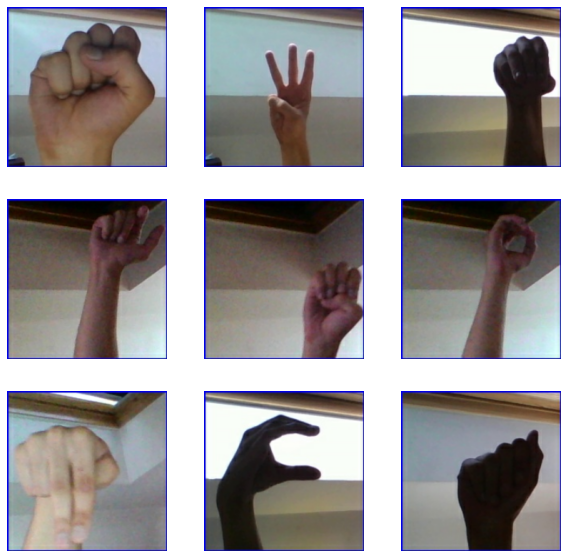

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    img = np.array(images[i])/255.0
    result = classifier.predict(img[np.newaxis])
    predicted_class = np.argmax(result[0], axis=-1)
    plt.axis("off")

In [66]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SHAPE+(3,), trainable=False)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(len(class_names), activation='softmax')
])
model.summary()
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

(32, 1280)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [68]:
steps_per_epoch = np.ceil(len(train_ds)/32)

batch_stats_callback = CollectBatchStats()

history = model.fit(images, labels, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[batch_stats_callback])

Epoch 1/2


ValueError: in user code:

    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:784 train_function  *
        return step_function(self, iterator)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:774 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1261 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2805 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3260 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:767 run_step  **
        outputs = model.train_step(data)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:734 train_step
        loss = self.compiled_loss(
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:148 __call__
        losses = ag_call(y_true, y_pred)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:252 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:1532 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\keras\backend.py:4803 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Development\Software\anaconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (1, 1) and (1, 29) are incompatible


In [ ]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

In [ ]:
# model.save(model_fp)